### Initial Setup

In [394]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
import re
import math
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [354]:
# Read in data
raw_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)

In [355]:
# Examine the data a little bit
print raw_data.shape
print raw_data.head()

(26729, 9)
             Name             DateTime      OutcomeType OutcomeSubtype  \
AnimalID                                                                 
A671945   Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
A656520     Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
A686464    Pearce  2015-01-31 12:28:00         Adoption         Foster   
A683430       NaN  2014-07-11 19:09:00         Transfer        Partner   
A667013       NaN  2013-11-15 12:52:00         Transfer        Partner   

         AnimalType SexuponOutcome AgeuponOutcome  \
AnimalID                                            
A671945         Dog  Neutered Male         1 year   
A656520         Cat  Spayed Female         1 year   
A686464         Dog  Neutered Male        2 years   
A683430         Cat    Intact Male        3 weeks   
A667013         Dog  Neutered Male        2 years   

                                Breed        Color  
AnimalID                                     

### Exploratory Data Analysis

#### Dog cat split

In [356]:
# Look at Proportion of dogs versus cats in the data
print raw_data.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64


There are more dogs than cats in the training data, but both types have a reasonable amount of data. 

#### Count proportion of neutered/intact female/male

In [357]:
# Look at Proportion of males veruss females in the data
print np.round(raw_data.SexuponOutcome.value_counts(normalize=True),2)

Neutered Male    0.37
Spayed Female    0.33
Intact Male      0.13
Intact Female    0.13
Unknown          0.04
Name: SexuponOutcome, dtype: float64


There are about the same numbers of male vs female. Interestingly, there are a lot fewer intact dogs and cats.

#### Handling age variable

Next we want to look at ages. However, the data appear to have different units (years/months/weeks/days). We will group them based on the following category:

1. Puppy - Less than 1 year old
2. Adult - Less than 7 years old
3. Old - 7 years and above

In [358]:
data = raw_data

In [359]:
# Convert age to numeric based on below definition:
# Age = 0 if age is less than 12 months. It is not necessary the best way to handle it because being 
data['AgeuponOutcome'] = data['AgeuponOutcome'].fillna('99 years')
def age_handle(data):
    out = []
    for i in range(0, len(data)):
        if 'year' in data[i]:
            temp = int(re.sub(' [a-z]+', '', data[i]))
            if temp >= 8:
                out.append('senior') #old
            elif temp <= 1:
                out.append('young adult') #adult
            elif temp <= 3:
                out.append('adult')
            else:
                out.append('older adult')
        elif 'month' in data[i]:
            temp = int(re.sub(' [a-z]+', '', data[i]))
            if temp <= 3:
                out.append('young pup')
            elif temp <= 6:
                out.append('pup')
            else:
                out.append('old pup')
        elif 'week' in data[i]:
            out.append('baby')
        elif 'day' in data[i]:
            out.append('infant')
    
    return out

data.AgeuponOutcome = age_handle(data.AgeuponOutcome)

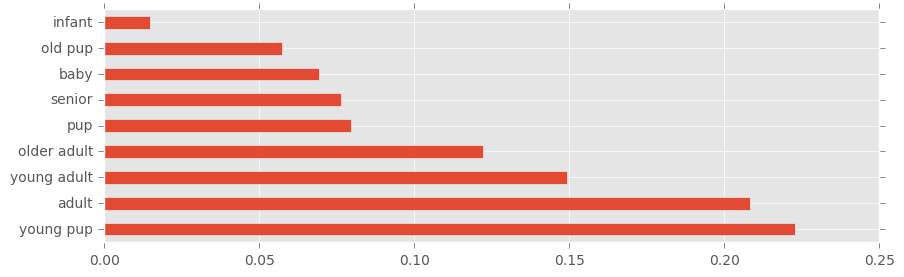

In [360]:
data.AgeuponOutcome.value_counts(normalize=True).plot(kind='barh', figsize=(10, 3))

It is interesting that many dogs and cats in the shelter are very young.

#### Outcome distribution

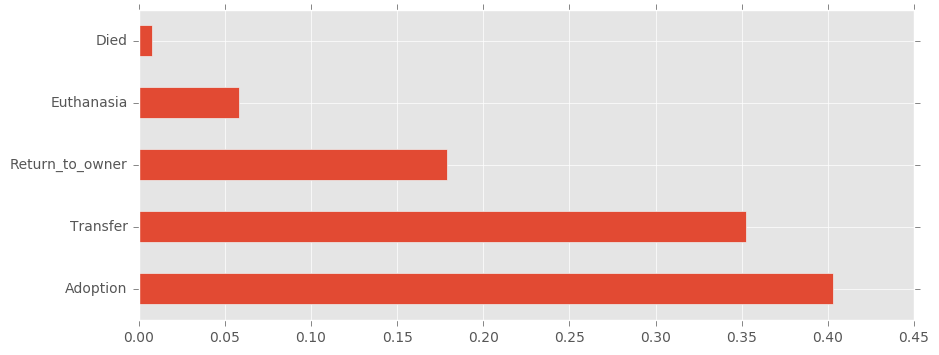

In [361]:
# Look at outcome distribution
data.OutcomeType.value_counts(normalize=True).plot(kind='barh', figsize=(10, 4))

It is great that most sheltered animals are either adopted or transferred. Only 6% of them are euthanasiaed. 

#### Target distribution based on age outcome

Next, we will look at the data based on the target variable to see if there are things that standout.

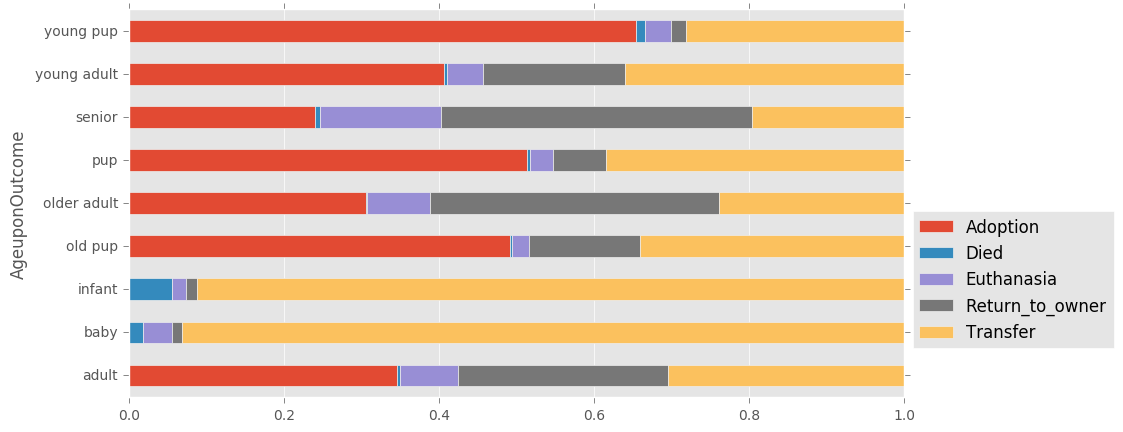

In [362]:
ax = data.groupby(by='AgeuponOutcome')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,5))
ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

** Observation **

Puppies are much more likely to be adopted or transferred compared to adult and old. They are also less likely to be euthanasia but more likely to die. On the other hand, old and adult animals are more likely to be returned to owners, relative to puppies. 

#### Target distribution based on animal type

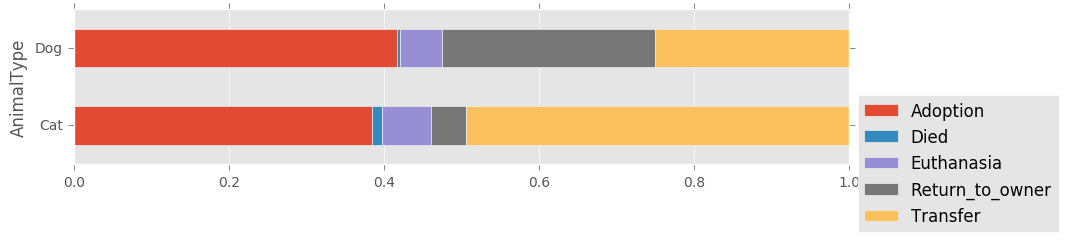

In [363]:
ax = data.groupby(by='AnimalType')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,2))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

** Observation **

There are couple interesting observation. First, cats' outcomes are disproportionally in the transfer category. Second, a lot more dogs were able to return to their owners than cats. It may indicate that the animal type can be a good feature to use. 

#### Target distribution based on sex and neutered status

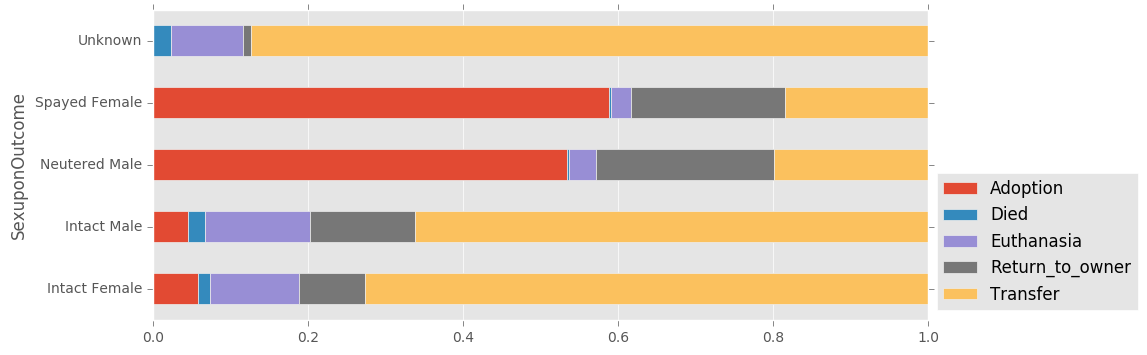

In [364]:
ax = data.groupby(by='SexuponOutcome')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

** Observation **

This data point shows that neutered or spayed pets are much more likely to be adopted. One reason could be the cost associated with undergoing such surgeries, which discourage adopters to choose an intacted pet. On the other hand, whether the sheltered animals are male or female does not seem to make a difference in terms of outcome. This information can be useful when we do feature engineering. Lastly, there is an "unknown" type that seems to be closer to intact female. 

#### Date time variable

First thing we want to do is to identify whether a date is a weekend or not. The intuition is that a weekend may lead to more adoption.

In [365]:
# Check whether it is a weekend. Weekend may lead to more adoption?
temp = pd.to_datetime(data['DateTime']).dt.weekday
data['weekend'] = temp.isin([5,6])


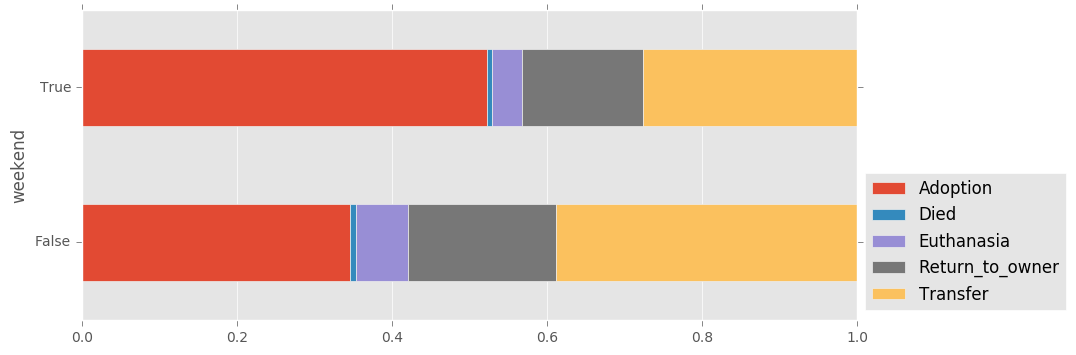

In [366]:
ax = data.groupby(by='weekend')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

**Observation**

The results are in line with our intuition. Additionally, we also see more pets transferred or euthanasia on weekdays, which make sense as well. We will have a weekend flag to be a feature as well. 

A second thing we want to do is to group the time to a more reasonable category like morning, afternoon, and night. The reason is that we do not believe there is information to be extracted for small incremental time difference. Here is how we group them:

1. Morning - Before 10am
2. Lunch - 10am to 2pm
3. Afternoon - 2pm to 5pm
4. Night After 5pm

In [367]:
temp = pd.to_datetime(data['DateTime']).dt.hour
bins = [0, 10, 14, 17, 24]
names = ['morning', 'lunch', 'afternoon', 'night']
data['OutcomeHour'] = pd.cut(temp, bins, labels=names)

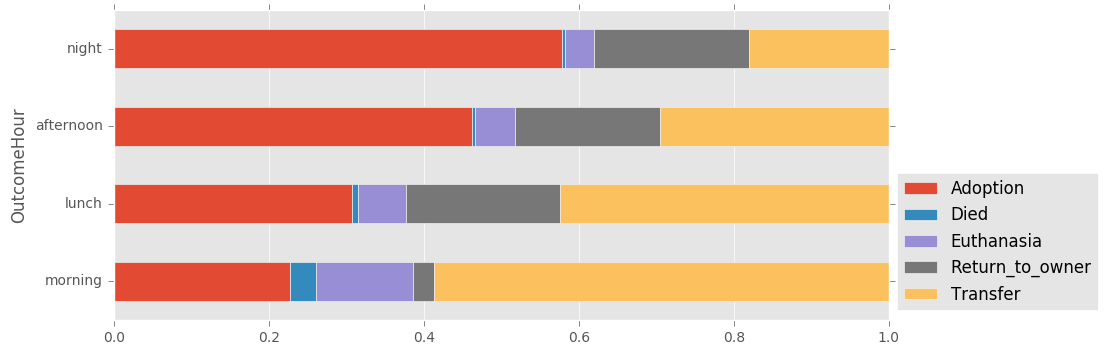

In [368]:
ax = data.groupby(by='OutcomeHour')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

In [369]:
data.OutcomeHour.value_counts()

lunch        9823
afternoon    9534
night        4887
morning      2107
Name: OutcomeHour, dtype: int64

** Observation **

Most events take place during lunch time and afternoon. It is interesting to see that most adoption happened after 5pm. Adopting a pet is a big decision and involved many procedures which could potentially delayed the final time of adoption.

On the other hand, Larger proportion of morning activities is euthanasia compared to other period. This seems to be in line with the typical practice in the shelter.  

#### Breed variable

There are way too many types of breed in the data. We will capture a group of dog breeds that are more popular in America. In terms of cat, we have looked at whether short/medium/long hair made a difference and the impact is not obvious. 

In [370]:
Names = ['german shepherd', 'labrador', 'golden retriever', 'beagle', 'bulldog', 'terrier', 'boxer', 'poodle', 'rottweiler', 'dachshund']

cv = CountVectorizer(vocabulary=Names)
test = cv.fit_transform(data['Breed'])
test = np.sum(test.toarray(), axis=1)
test[test==2] = 1
data['popular'] = test

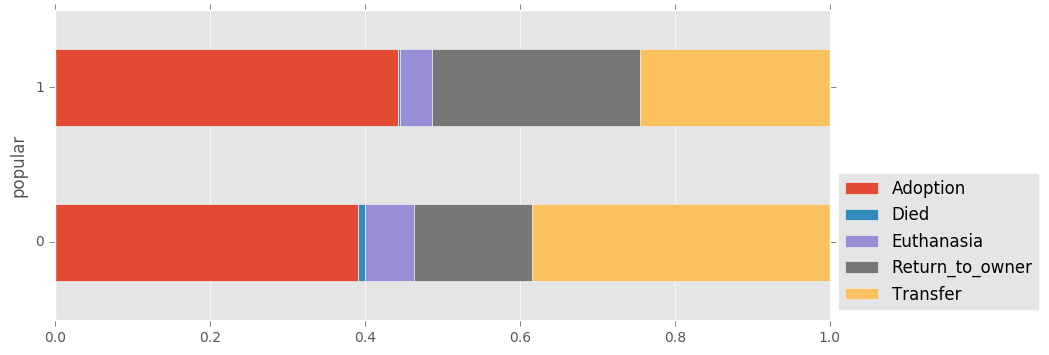

In [371]:
ax = data.groupby(by='popular')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

#### Color variable

In [372]:
data.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,weekend,OutcomeHour,popular
AnimalID,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,young adult,Shetland Sheepdog Mix,Brown/White,False,night,0
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,young adult,Domestic Shorthair Mix,Cream Tabby,True,lunch,0
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,adult,Pit Bull Mix,Blue/White,True,lunch,0
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,baby,Domestic Shorthair Mix,Blue Cream,False,night,0
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,adult,Lhasa Apso/Miniature Poodle,Tan,False,lunch,1


We will interpet '/' as mix color

In [373]:
temp = ['/' in data.Color[x] for x in range(0, len(data.Color))]
data['MixColor'] = temp

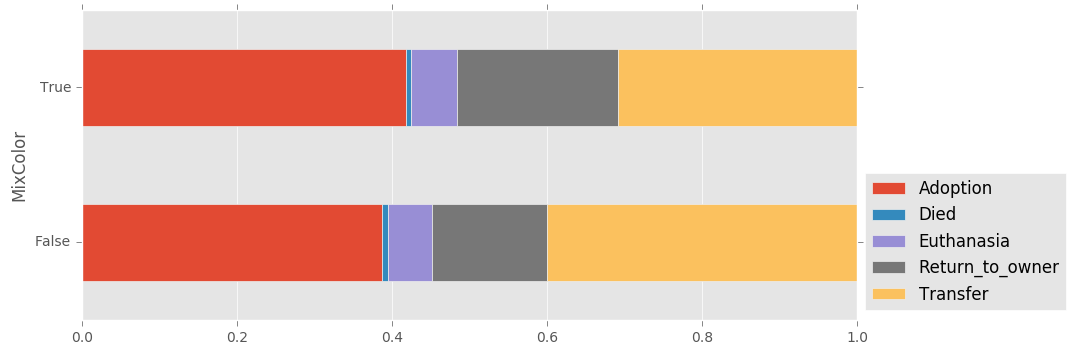

In [374]:
ax = data.groupby(by='MixColor')['OutcomeType'].value_counts(normalize=True).unstack().plot(kind='barh', stacked='True', figsize=(10,4))
ax.legend(loc='best', bbox_to_anchor=(1.0,0.5))

### Data manipulation


####  Convert string to numeric categories

In [375]:
le = preprocessing.LabelEncoder()
data['AnimalType'] = le.fit_transform(data['AnimalType'])
test_data['AnimalType'] = le.fit_transform(test_data['AnimalType'])

In [376]:
data.replace(to_replace=['Unknown','nan', 'NaN', 'Intact Male', 'Intact Female'], value=1, inplace=True)
data.replace(to_replace=['Neutered Male', 'Spayed Female'], value=0, inplace=True)
data.replace(to_replace='nan', value=1, inplace=True)

test_data.replace(to_replace=['Unknown','nan', 'NaN', 'Intact Male', 'Intact Female'], value=1, inplace=True)
test_data.replace(to_replace=['Neutered Male', 'Spayed Female'], value=0, inplace=True)
test_data.replace(to_replace='nan', value=1, inplace=True)

In [377]:
data['AgeuponOutcome'] = le.fit_transform(data['AgeuponOutcome'])
data['weekend'] = le.fit_transform(data['weekend'])
data['OutcomeHour'] = le.fit_transform(data['OutcomeHour'])
data['OutcomeType'] = le.fit_transform(data['OutcomeType'])

In [378]:
outcome_names = le.classes_

#### Standardize features

### Determine features that are applicable

In [379]:
labels = data.OutcomeType
data = data.drop('OutcomeType', 1)

In [381]:
feature_names = ['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'weekend', 'OutcomeHour', 'popular', 'MixColor']
final_data = data.loc[:, feature_names]
train_data, dev_data, train_labels, dev_labels = train_test_split(final_data, labels, test_size=0.3, random_state=0)

In [382]:
std_scaler = StandardScaler()
std_train_data = std_scaler.fit_transform(train_data)
std_dev_data = std_scaler.fit_transform(dev_data)

### Apply machine learning techniques

In [399]:
# Logictic regression
#mdl = KNeighborsClassifier(n_neighbors=40, weights='uniform')
#mdl = LogisticRegression(penalty='l2', C=1)
#mdl = RandomForestClassifier(n_estimators=50, max_depth=20)
clf = GradientBoostingClassifier(learning_rate=0.02, n_estimators=800,
                        subsample=0.8)
#param_dist = {'n_estimators': sp_randint(100, 800)}
parameters = {'n_estimators':[100, 800]}
mdl = GridSearchCV(clf, parameters)

#mdl = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20)

mdl.fit(train_data, train_labels)
prediction = mdl.predict(dev_data)

# Prediction accuracy
print 'Prediction accuracy:', np.mean(prediction == dev_labels)

Prediction accuracy: 0.653198653199


In [400]:
pred_prob = mdl.predict_proba(dev_data)
pred_prob = pred_prob + 0.000000001   # A hack to deal with log transformation of zero

#### Kaggle evaluation matrix

In [401]:
-np.mean([np.log(pred_prob[x,dev_labels[x]]) for x in range(0, len(pred_prob))])

0.83588747910220651

In [402]:
test = pd.DataFrame(prediction, columns = ['prediction'])
print outcome_names
test.prediction.value_counts()


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']


0    4076
4    2608
3    1255
2      80
Name: prediction, dtype: int64

In [ ]:
# Make predictions of test data
#prediction = mdl.predict_proba(test_data.loc[:,['AnimalType','SexuponOutcome']])

In [ ]:
# Format an output file
#out = np.zeros((prediction.shape[0], 5))

#for i in range(out.shape[0]):
#    out[i, prediction[i]] = 1

# Convert to panda dataframe
#out = pd.DataFrame(data=prediction, index=test_data.ID, columns=['Return_to_owner','Adoption','Euthanasia','Transfer','Died'])

In [ ]:
#out.head()

In [ ]:
#out.to_csv('results.csv')